### Target:

* To increase the capacity of model
* To acheive 99.4% accuracy

### Results:

* Parameters: 9.1k
* Best Train Accuracy: 99.02
* Best Test Accuracy: 99.36

### Analysis:
* The model has less than 10k parameters
* Increasing the capacity has helped the model to learn model


# Import Libraries

In [1]:
from __future__ import print_function
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms

## Data Transformations

We first start with defining our data transformations. We need to think what our data is and how can we augment it to correct represent images which it might not see otherwise. 


In [13]:
# Train Phase transformations
train_transforms = transforms.Compose([
                                      #  transforms.Resize((28, 28)),
                                      #  transforms.ColorJitter(brightness=0.10, contrast=0.1, saturation=0.10, hue=0.1),
                                       transforms.ToTensor(),
                                    #    transforms.ToPILImage(),
                                       transforms.RandomRotation((-10.0, 10.0), fill=(1,)),
                                       transforms.Normalize((0.1307,), (0.3081,)) # The mean and std have to be sequences (e.g., tuples), therefore you should add a comma after the values. 
                                       # Note the difference between (0.1307) and (0.1307,)
                                       ])

# Test Phase transformations
test_transforms = transforms.Compose([
                                      #  transforms.Resize((28, 28)),
                                      #  transforms.ColorJitter(brightness=0.10, contrast=0.1, saturation=0.10, hue=0.1),
                                       transforms.ToTensor(),
                                       transforms.Normalize((0.1307,), (0.3081,))
                                       ])


# Dataset and Creating Train/Test Split

In [14]:
train = datasets.MNIST('./data', train=True, download=True, transform=train_transforms)
test = datasets.MNIST('./data', train=False, download=True, transform=test_transforms)

# Dataloader Arguments & Test/Train Dataloaders


In [15]:
SEED = 1

# CUDA?
cuda = torch.cuda.is_available()
print("CUDA Available?", cuda)

# For reproducibility
torch.manual_seed(SEED)

if cuda:
    torch.cuda.manual_seed(SEED)

# dataloader arguments - something you'll fetch these from cmdprmt
dataloader_args = dict(shuffle=True, batch_size=128, num_workers=4, pin_memory=True) if cuda else dict(shuffle=True, batch_size=64)

# train dataloader
train_loader = torch.utils.data.DataLoader(train, **dataloader_args)

# test dataloader
test_loader = torch.utils.data.DataLoader(test, **dataloader_args)

CUDA Available? True


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


# Data Statistics

It is important to know your data very well. Let's check some of the statistics around our data and how it actually looks like

/usr/local/lib/python3.7/dist-packages/torchvision/datasets/mnist.py:62: UserWarning: train_data has been renamed data
  warnings.warn("train_data has been renamed data")


[Train]
 - Numpy Shape: (60000, 28, 28)
 - Tensor Shape: torch.Size([60000, 28, 28])
 - min: tensor(-0.4242)
 - max: tensor(2.8215)
 - mean: tensor(2.8066)
 - std: tensor(0.2168)
 - var: tensor(0.0470)


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


torch.Size([128, 1, 28, 28])
torch.Size([128])


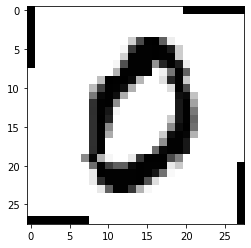

In [16]:
# We'd need to convert it into Numpy! Remember above we have converted it into tensors already
train_data = train.train_data
train_data = train.transform(train_data.numpy())

print('[Train]')
print(' - Numpy Shape:', train.train_data.cpu().numpy().shape)
print(' - Tensor Shape:', train.train_data.size())
print(' - min:', torch.min(train_data))
print(' - max:', torch.max(train_data))
print(' - mean:', torch.mean(train_data))
print(' - std:', torch.std(train_data))
print(' - var:', torch.var(train_data))

dataiter = iter(train_loader)
images, labels = dataiter.next()

print(images.shape)
print(labels.shape)

# Let's visualize some of the images
%matplotlib inline
import matplotlib.pyplot as plt

plt.imshow(images[0].numpy().squeeze(), cmap='gray_r')


## MORE

It is important that we view as many images as possible. This is required to get some idea on image augmentation later on

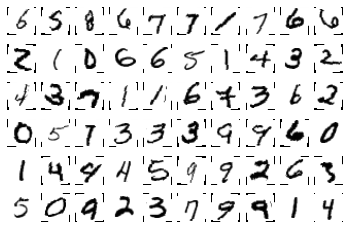

In [17]:




figure = plt.figure()
num_of_images = 60
for index in range(1, num_of_images + 1):
    plt.subplot(6, 10, index)
    plt.axis('off')
    plt.imshow(images[index].numpy().squeeze(), cmap='gray_r')


# The model
Let's start with the model we first saw

In [18]:

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        #Input Block
        self.convblock_1 = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=10, kernel_size=3, padding=0, bias=False),
            nn.ReLU(),
            nn.BatchNorm2d(10),
            nn.Dropout2d(0.01)
        ) # output_size = 26*26*5

        self.convblock_2 = nn.Sequential(
            nn.Conv2d(in_channels=10, out_channels=15, kernel_size=3, padding=0, bias=False),
            nn.ReLU(),
            nn.BatchNorm2d(15),
            nn.Dropout2d(0.01)
        ) # output_size = 24*24*10
        
        # Transition block
        self.maxPool = nn.MaxPool2d(2,2)#output=12*12*10

        self.convblock_3 = nn.Sequential(
            nn.Conv2d(in_channels=15, out_channels=20, kernel_size=3, padding=0, bias=False),
            nn.ReLU(),
            nn.BatchNorm2d(20),
            nn.Dropout2d(0.01)
        )#output= 10*10*15

        self.convblock_4 = nn.Sequential(
            nn.Conv2d(in_channels=20, out_channels=15, kernel_size=3, padding=0, bias=False),
            nn.ReLU(),
            nn.BatchNorm2d(15),
            nn.Dropout2d(0.01)
        )#output = 8*8*20

        self.convblock_5 = nn.Sequential(
            nn.Conv2d(in_channels=15, out_channels=15, kernel_size=3, padding=0, bias=False),
            nn.ReLU(),
            nn.BatchNorm2d(15),
            nn.Dropout2d(0.01)
        )#output = 6*6*20

        #Output Block
        self.gap = nn.AvgPool2d(6)#output=1*1*20

        self.convblock_6 = nn.Sequential(
            nn.Conv2d(in_channels=15, out_channels=10, kernel_size=1, padding=0, bias=False)
        )#1*1*10


    def forward(self, x):
        
        x = self.convblock_1(x)
        x = self.convblock_2(x)
        x = self.maxPool(x)
        x = self.convblock_3(x)
        x = self.convblock_4(x)
        x = self.convblock_5(x)
        x = self.gap(x)
        x = self.convblock_6(x)
      
        x = x.reshape(-1,10)

        return F.log_softmax(x, dim=-1)


# Model Params
Can't emphasize on how important viewing Model Summary is. 
Unfortunately, there is no in-built model visualizer, so we have to take external help

In [19]:
!pip install torchsummary
from torchsummary import summary
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
print(device)
model = Net().to(device)
summary(model, input_size=(1, 28, 28))

cuda
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 10, 26, 26]              90
              ReLU-2           [-1, 10, 26, 26]               0
       BatchNorm2d-3           [-1, 10, 26, 26]              20
         Dropout2d-4           [-1, 10, 26, 26]               0
            Conv2d-5           [-1, 15, 24, 24]           1,350
              ReLU-6           [-1, 15, 24, 24]               0
       BatchNorm2d-7           [-1, 15, 24, 24]              30
         Dropout2d-8           [-1, 15, 24, 24]               0
         MaxPool2d-9           [-1, 15, 12, 12]               0
           Conv2d-10           [-1, 20, 10, 10]           2,700
             ReLU-11           [-1, 20, 10, 10]               0
      BatchNorm2d-12           [-1, 20, 10, 10]              40
        Dropout2d-13           [-1, 20, 10, 10]               0
           Conv2d-14             [

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


# Training and Testing

Looking at logs can be boring, so we'll introduce **tqdm** progressbar to get cooler logs. 

Let's write train and test functions

In [20]:
from tqdm import tqdm

train_losses = []
test_losses = []
train_acc = []
test_acc = []

def train(model, device, train_loader, optimizer, epoch):
  model.train()
  pbar = tqdm(train_loader)
  correct = 0
  processed = 0
  for batch_idx, (data, target) in enumerate(pbar):
    # get samples
    data, target = data.to(device), target.to(device)

    # Init
    optimizer.zero_grad()
    # In PyTorch, we need to set the gradients to zero before starting to do backpropragation because PyTorch accumulates the gradients on subsequent backward passes. 
    # Because of this, when you start your training loop, ideally you should zero out the gradients so that you do the parameter update correctly.

    # Predict
    y_pred = model(data)

    # Calculate loss
    loss = F.nll_loss(y_pred, target)
    train_losses.append(loss)

    # Backpropagation
    loss.backward()
    optimizer.step()

    # Update pbar-tqdm
    
    pred = y_pred.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
    correct += pred.eq(target.view_as(pred)).sum().item()
    processed += len(data)

    pbar.set_description(desc= f'Loss={loss.item()} Batch_id={batch_idx} Accuracy={100*correct/processed:0.2f}')
    train_acc.append(100*correct/processed)

def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)
    test_losses.append(test_loss)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))
    
    test_acc.append(100. * correct / len(test_loader.dataset))

# Let's Train and test our model

In [21]:
model =  Net().to(device)
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
EPOCHS = 15
for epoch in range(EPOCHS):
    print("EPOCH:", epoch)
    train(model, device, train_loader, optimizer, epoch)
    test(model, device, test_loader)

EPOCH: 0


  0%|          | 0/469 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
Loss=0.0870109423995018 Batch_id=468 Accuracy=86.49: 100%|██████████| 469/469 [00:36<00:00, 12.74it/s]



Test set: Average loss: 0.0839, Accuracy: 9779/10000 (97.79%)

EPOCH: 1


Loss=0.05789924040436745 Batch_id=468 Accuracy=97.30: 100%|██████████| 469/469 [00:36<00:00, 12.91it/s]



Test set: Average loss: 0.0475, Accuracy: 9875/10000 (98.75%)

EPOCH: 2


Loss=0.12391442060470581 Batch_id=468 Accuracy=97.93: 100%|██████████| 469/469 [00:35<00:00, 13.03it/s]



Test set: Average loss: 0.0400, Accuracy: 9886/10000 (98.86%)

EPOCH: 3


Loss=0.033004045486450195 Batch_id=468 Accuracy=98.18: 100%|██████████| 469/469 [00:35<00:00, 13.05it/s]



Test set: Average loss: 0.0316, Accuracy: 9908/10000 (99.08%)

EPOCH: 4


Loss=0.050490494817495346 Batch_id=468 Accuracy=98.39: 100%|██████████| 469/469 [00:36<00:00, 12.88it/s]



Test set: Average loss: 0.0322, Accuracy: 9902/10000 (99.02%)

EPOCH: 5


Loss=0.03517092391848564 Batch_id=468 Accuracy=98.47: 100%|██████████| 469/469 [00:36<00:00, 12.95it/s]



Test set: Average loss: 0.0290, Accuracy: 9918/10000 (99.18%)

EPOCH: 6


Loss=0.044532615691423416 Batch_id=468 Accuracy=98.61: 100%|██████████| 469/469 [00:36<00:00, 12.82it/s]



Test set: Average loss: 0.0238, Accuracy: 9929/10000 (99.29%)

EPOCH: 7


Loss=0.03050231747329235 Batch_id=468 Accuracy=98.70: 100%|██████████| 469/469 [00:36<00:00, 12.90it/s]



Test set: Average loss: 0.0237, Accuracy: 9927/10000 (99.27%)

EPOCH: 8


Loss=0.0627208799123764 Batch_id=468 Accuracy=98.69: 100%|██████████| 469/469 [00:36<00:00, 12.85it/s]



Test set: Average loss: 0.0309, Accuracy: 9907/10000 (99.07%)

EPOCH: 9


Loss=0.004198529291898012 Batch_id=468 Accuracy=98.84: 100%|██████████| 469/469 [00:36<00:00, 13.00it/s]



Test set: Average loss: 0.0227, Accuracy: 9926/10000 (99.26%)

EPOCH: 10


Loss=0.010010340251028538 Batch_id=468 Accuracy=98.83: 100%|██████████| 469/469 [00:36<00:00, 12.90it/s]



Test set: Average loss: 0.0252, Accuracy: 9922/10000 (99.22%)

EPOCH: 11


Loss=0.02704509161412716 Batch_id=468 Accuracy=98.86: 100%|██████████| 469/469 [00:35<00:00, 13.06it/s]



Test set: Average loss: 0.0226, Accuracy: 9927/10000 (99.27%)

EPOCH: 12


Loss=0.0457506887614727 Batch_id=468 Accuracy=98.89: 100%|██████████| 469/469 [00:36<00:00, 12.90it/s]



Test set: Average loss: 0.0214, Accuracy: 9936/10000 (99.36%)

EPOCH: 13


Loss=0.02853110246360302 Batch_id=468 Accuracy=98.95: 100%|██████████| 469/469 [00:36<00:00, 12.99it/s]



Test set: Average loss: 0.0211, Accuracy: 9934/10000 (99.34%)

EPOCH: 14


Loss=0.0053845359943807125 Batch_id=468 Accuracy=99.02: 100%|██████████| 469/469 [00:36<00:00, 12.93it/s]



Test set: Average loss: 0.0205, Accuracy: 9936/10000 (99.36%)



Text(0.5, 1.0, 'Test Accuracy')

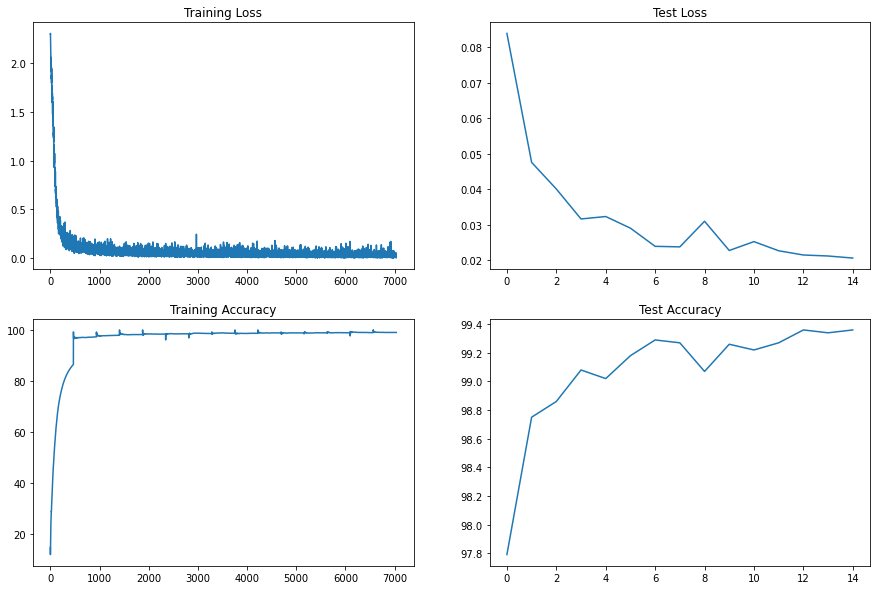

In [22]:
fig, axs = plt.subplots(2,2,figsize=(15,10))
axs[0, 0].plot(train_losses)
axs[0, 0].set_title("Training Loss")
axs[1, 0].plot(train_acc)
axs[1, 0].set_title("Training Accuracy")
axs[0, 1].plot(test_losses)
axs[0, 1].set_title("Test Loss")
axs[1, 1].plot(test_acc)
axs[1, 1].set_title("Test Accuracy")